<div style="background-color:royalblue">
<img src="https://d3njjcbhbojbot.cloudfront.net/web/bundles/userModal/images/coursera-logo.svg">
</div>    

# <b style="color:#3b5998">www-coursera-downloader </b>

- this release: 20160628
- features: 
  - quiz downloader
  - html reading downloader
  - video downloader
  - creation of m3u playlist
  - added  <b style="color:#3b5998">colorful</b> heading and images
  - added section `download another course?`

(c) Jansen Simanullang, 2016-2018.

## <b style="color:#3b5998">A. Requirements</b>

### <b style="color:#3b5998">(1) Install Mozilla Geckodriver</b>
<img src="https://avatars2.githubusercontent.com/u/131524?s=200&v=4" width="75" height="75" alt="@mozilla" align="center"><br>
<li>Install [Mozilla Geckodriver](https://github.com/mozilla/geckodriver/releases/)
</li>

#### <b style="color:royalblue">Check Geckodriver version</b>

In [1]:
!echo Checking geckodriver version...
!geckodriver --version

Checking geckodriver version...
geckodriver 0.20.1

The source code of this program is available from
testing/geckodriver in https://hg.mozilla.org/mozilla-central.

This program is subject to the terms of the Mozilla Public License 2.0.
You can obtain a copy of the license at https://mozilla.org/MPL/2.0/.


### <b style="color:#3b5998">(2) Install Some Python Packages</b>
<img src="https://pypi.org/static/images/logo-small.6eef541e.svg">

In [2]:
!pip install -q bs4 jupyter_contrib_nbextensions mutagen pillow requests splinter
!jupyter nbextension enable python-markdown/main

Enabling notebook extension python-markdown/main...
      - Validating: OK


In [3]:
from splinter import Browser
import base64, getpass, json, os, re, requests, sys, time
from bs4 import BeautifulSoup
from mutagen.mp4 import MP4

## <b style="color:#3b5998">B. Definitions</b>

### <b style="color:royalblue">B. 1 Some constants</b>

In [4]:
# LOADING TIME
# WARNING: this will impact your user experience!
# adjust loading time according to your network speed!
# loading time in seconds

loading_time = 5

# HOMEPAGE
homepage='https://www.coursera.org'

# VIDEO RESOLUTION
# available resolution:
# 'hi', 'low' or 'med'
# choose according to your preference
resolution = {'low':'360','med':'540','hi':'720'}
chosen_res = 'hi'

# INITIAL DIRECTORY
initial_dirname = os.getcwd()

###  <b style="color:royalblue">B.2 Helper Functions</b>

<img src="https://www.3di.co.uk/wp-content/uploads/2016/06/Define.png" height="150" width="250">

In [46]:
def safe_text(str_text):
    erasable = [':','/']
    for e in erasable:   
        str_text = str_text.replace(e, ' ')  
    while '  ' in str_text:
        str_text = str_text.replace('  ',' ')
    return str_text

def create_download_dir(dirname):
    
    dirname = safe_text(dirname)
    
    try:
        os.mkdir(dirname)
    except:
        pass
    
    os.chdir(dirname)
    print(os.getcwd())

# SCREENSHOT
def screenshot():
    browser.driver.save_screenshot('screenshot.png')
    from PIL import Image
    return Image.open('screenshot.png')

# cjson helper functions

def encode_cjson(text):
    return base64.b64encode(bytes(str(text), "utf-8"))

def save_cjson(text):
    text = encode_cjson(text)
    with open('coursera.json','wb+') as f:
        f.write(bytes(str(text),"utf-8"))
    f.close()

def read_cjson():
    
    if os.path.isfile('coursera.json'):
        with open('coursera.json','rb') as f:
            a = f.read()
        f.close()
    else:
        print('credential file not found')
    return str(a).split("'")[1]

def decode_cjson(text):
    return str(base64.b64decode(text)).split("'")[1]

def get_cjson():

    text = read_cjson()
    
    uid = json.loads(decode_cjson(text))
    return uid

def remove_cjson():
    
    if os.path.isfile('coursera.json'):
        os.remove('coursera.json')

def get_credential():

    if os.path.isfile('coursera.json'):
        username = get_cjson()['user']
        password = get_cjson()['password']
    else:
        username = input('User Name:')
        password = getpass.getpass('Password:')
        text = '{"user":"'+username+'", "password":"'+password+'"}'
        save_cjson(text)
        
    return username, password

def remove_credential():
    remove_cjson()
    print('credential removed...')
    return

def reset_credential():
    remove_cjson()
    username, password = get_credential()
    return username, password

# vtt file conversion

def read_text_file(file_name):
    f = open(file_name, "r")
    print("vtt file being converted to srt: " + file_name + "\n")  
    return f.read()

def file_create(file_name, str_data):
    try:  
        f = open(file_name, "w")
        f.writelines(str(str_data))
        f.close()
    except IOError:        
        file_name = file_name.split(os.sep)[-1]
        f = open(file_name, "w")
        f.writelines(str(str_data))
        f.close()
    print("file created: " + file_name + "\n")
    
def convert_content(file_contents):
    replacement = re.sub(r'([\d]+)\.([\d]+)', r'\1,\2', file_contents)
    replacement = re.sub(r'WEBVTT\n\n', '', replacement)
    replacement = re.sub(r'^\d+\n', '', replacement)
    replacement = re.sub(r'\n\d+\n', '\n', replacement)
    return replacement

def vtt_to_srt(file_name):
    
    file_contents = read_text_file(file_name)
    str_data = ""
    str_data = str_data + convert_content(file_contents)  
    file_name = file_name.replace(".vtt",".srt")
    print(file_name)
    file_create(file_name, str_data)
    
# 
    
def get_mp4_url(lesson_url):
    
    if lesson_url not in browser.driver.current_url:
        browser.visit(homepage+lesson_url)
        time.sleep(loading_time)
        print('video playing will be paused in ' + str(loading_time) + ' seconds...')
        time.sleep(loading_time)
    try:
        browser.find_by_css('span.cif-2x.cif-fw.cif-pause').click()
    except:
        time.sleep(loading_time)
        try:
            browser.find_by_css('span.cif-2x.cif-fw.cif-pause').click()
        except:
            pass
        pass
    mp4 = browser.find_by_tag('video').find_by_tag('source')['src']
    mp4 = mp4.replace('360p/',resolution[chosen_res]+'p/')
    return mp4

def get_vtt_url(lesson_url):
    if lesson_url not in browser.driver.current_url:
        browser.visit(homepage+lesson_url)
        time.sleep(loading_time)
    element = browser.find_by_css('li.rc-SubtitleDownloadItem.resource-list-item')
    vtt = BeautifulSoup(element.html, 'lxml').findAll('a')[0]['href']
    vtt = homepage + vtt
    return vtt

In [47]:
def vtt_downloader(lesson_id, lesson_title, lesson_url):
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)    
    file_name = base_filename + '.vtt'
    file_exists = os.path.isfile(file_name)

    if file_exists:
        print('subtitle already downloaded.')
    else:
        vtt = get_vtt_url(lesson_url)
        r = requests.get(vtt)
        f = open(file_name, 'w')
        f.write(r.text)
        f.close()
    vtt_to_srt(file_name)
        
def mp4_downloader(lesson_id, lesson_title, lesson_url):
    
    mp4 = get_mp4_url(lesson_url)
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    file_name = base_filename + '.mp4'

    downloaded_size = 0
    buffer_size = 1024

    print('requesting to download...')
    r = requests.get(mp4)
    content_length = r.headers['Content-Length']
    download_size = int(content_length)
    file_exists = os.path.isfile(file_name)
    
    if file_exists:
        
        if os.path.getsize(file_name) == download_size:
            print('mp4 already downloaded.')
            
    elif not file_exists:
        
        if r.status_code == 200:
            f = open(file_name, 'wb')
            for buffer in r.iter_content(buffer_size):
                f.write(buffer)
                downloaded_size += buffer_size
                status='\rdownloading...' + file_name + '>>> '
                status = status +str("{:.2f}".format(downloaded_size * 100. /download_size))+'%'
                sys.stdout.write(status)
                sys.stdout.flush()
            f.close()
        else:
            print('please check your connection..')

In [48]:
def reformat_html(html, page_title):
    
    # reading
    html = html.replace('<div class="rc-ItemBox rc-ReadingItem"><div class="item-box-content"><div>',
                  '<div class="rc-ItemBox rc-ReadingItem"><div class="item-box-content"><div> <h2 class="flex-1 align-self-center headline-4-text">'+page_title+'</h2>')

    html = html.replace('<div class="Box_120drhm-o_O-endJustify_b0g9ud-o_O-displayflex_poyjc" style="margin: 60px -60px -60px; border-top: 1px solid rgb(221, 221, 221); padding: 15px;"><div class="rc-ItemFeedback"><div class="rc-ItemFeedbackContent horizontal-box"><div class="rc-Like"><div class="rc-LikeContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Like"><i class="fa cif-thumbs-o-up" aria-hidden="true"></i></button></div><span></span></div></div><div class="rc-Dislike"><div class="rc-LikeContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Dislike"><i class="cif-thumbs-o-down" aria-hidden="true"></i></button></div><span></span></div></div><div class="rc-Flag"><div class="rc-FlagContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Report problem"><i class="cif-flag-o" aria-hidden="true"></i></button></div><span></span></div></div></div></div></div></div></div>',
                        '')
    
    return html    
    
def reformat_html_quiz(html, page_title):    
    # quiz
    html = html.replace('<div class="header-back-arrow"><button class="back nostyle" role="button" tabindex="0"><i class="cif-back headline-2-text"></i><span class="screenreader-only">Back</span></button></div>',
                        '')
    html = html.replace('<div data-rc="ItemFeedback" class="c-quiz-item-feedback"><div data-reactroot="" class="rc-ItemFeedback"><div class="rc-ItemFeedbackContent horizontal-box"><div class="rc-Like"><div class="rc-LikeContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Like"><i class="fa cif-thumbs-o-up" aria-hidden="true"></i></button></div><span></span></div></div><div class="rc-Dislike"><div class="rc-LikeContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Dislike"><i class="cif-thumbs-o-down" aria-hidden="true"></i></button></div><span></span></div></div><div class="rc-Flag"><div class="rc-FlagContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Report problem"><i class="cif-flag-o" aria-hidden="true"></i></button></div><span></span></div></div></div></div></div>',
                        '')
    
    return html

def write_html(base_filename, html):
    
    html = reformat_html(html, base_filename)
    file_name = base_filename + '.html'
    f = open(file_name, 'w')
    html = '<html><head><link href="https://d3njjcbhbojbot.cloudfront.net/webapps/builds/ondemand/app.07c9f4ac0583c6e2d2d1.css" rel="stylesheet"></head><body>'+html+'</body></html>'
    f.write(html)
    f.close()
    
def write_html_quiz(base_filename, html):
    
    html = reformat_html_quiz(html, base_filename)
    file_name = base_filename + '.html'
    f = open(file_name, 'w')
    html = '<html><head><link href="https://d3njjcbhbojbot.cloudfront.net/webapps/builds/ondemand/app.07c9f4ac0583c6e2d2d1.css" rel="stylesheet"></head><body>'+html+'</body></html>'
    f.write(html)
    f.close()
    
def quiz_downloader(lesson_id, lesson_title, lesson_url):
    
    if lesson_url not in browser.driver.current_url:
        browser.visit(homepage+lesson_url)
        time.sleep(loading_time)
        
    try:
        buttons = browser.find_by_css('button')
        for button in buttons:
            if(button.text) == 'Continue':
                print(button.text)
                button.click()    
    except:
        pass
    
    try:
        time.sleep(loading_time)
        buttons = browser.find_by_css('button')
        for button in buttons:
            if(button.text) == 'Start' or button.text == 'Resume':
                print(button.text)
                button.click()
                break
        try:
            time.sleep(loading_time)
            html = browser.find_by_css('div.rc-FullscreenLayoutHandler').html
            print('got quiz item')
            base_filename = lesson_id +'-'+ safe_text(lesson_title)
            write_html_quiz(base_filename, html)
        except:
            print('no quiz content scraped.')
            pass
    except:
        print('something wrong...')
        html ='no quiz content scraped.'
        pass
    

    
def html_downloader(lesson_id, lesson_title, lesson_url):
    
    if lesson_url not in browser.driver.current_url:
        browser.visit(homepage+lesson_url)
        time.sleep(loading_time)
        
    try:
        html = browser.find_by_css('div.item-page-content').html
        print('got reading item')
    except:
        html ='no content scraped.'
        pass
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    write_html(base_filename, html)
    
    return

def check_html_reading(lesson_id, lesson_title, lesson_url):
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    file_name = base_filename + '.html'
    
    file_exists = os.path.isfile(file_name)
    if file_exists:
        print('html already downloaded.')
    else:
        html_downloader(lesson_id, lesson_title, lesson_url)
        
### CREATE m3u PLAYLIST FILE
def create_m3u_playlist(course_title):
    
    seq = 0
    m3u_text = '#EXTM3U'+'\n'
    for root, dirs, files in os.walk(os.getcwd(), topdown=False):
        for name in sorted(files):
            if 'mp4' in name:
                seq += 1
                mp4 = os.path.join(root, name)
                m3u_text += ('#EXTINF:'+str(int((MP4(mp4).info.length)))+','+ name) + '\n'
                m3u_text += (mp4) + '\n'
    playlist_base_name = safe_text(course_title).replace(' ','-')
    playlist_name = '000-'+playlist_base_name + '.m3u'
    f = open(playlist_name, 'w')
    f.write(m3u_text)
    f.close()
    print('playlist file created: '+playlist_name)

##  <b style="color:#3b5998">C. Coursera</b>

###  <b style="color:royalblue">(1) Login Page</b>


In [8]:
browser = Browser('firefox', headless = True)

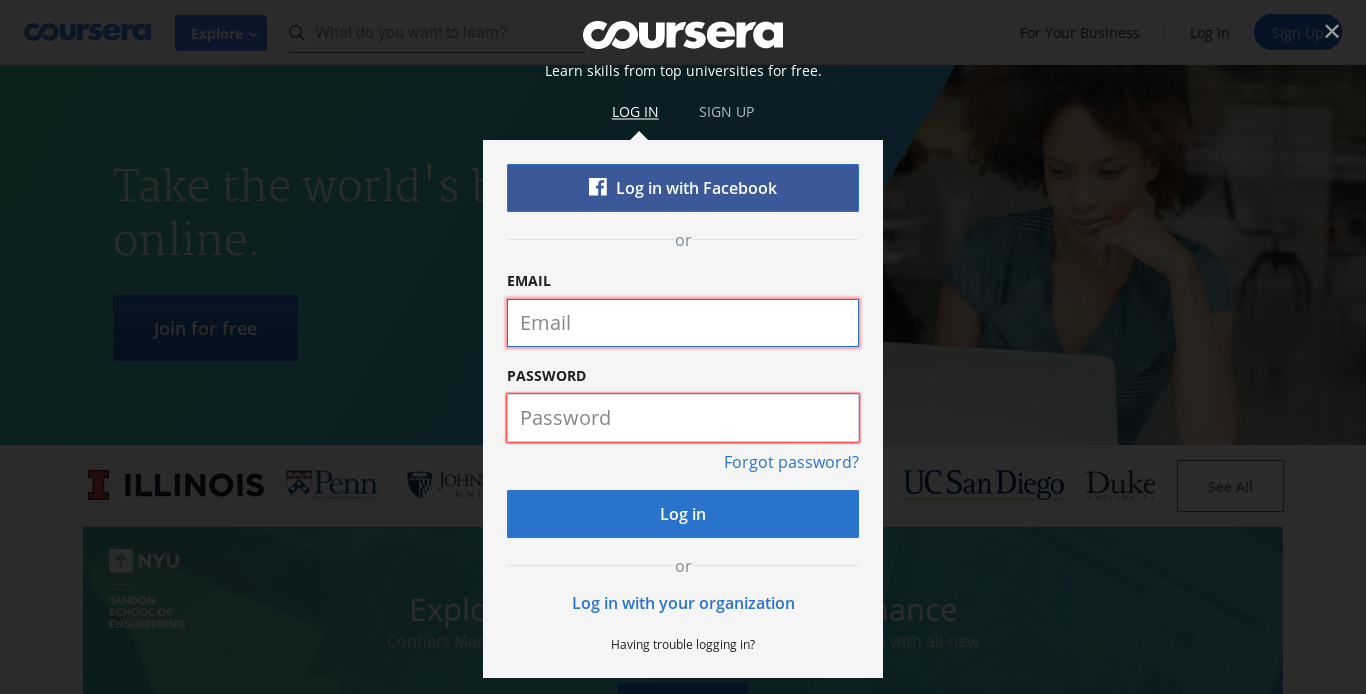

In [9]:
browser.visit('https://www.coursera.org/?authMode=login')
screenshot()

###  <b style="color:royalblue">Insert Login Credential</b>

In [10]:
#reset_credential() #uncomment to reset 
username, password = get_credential()

In [11]:
browser.visit('https://www.coursera.org/courses?authMode=login')

In [12]:
browser.fill('email', username)
browser.fill('password', password)

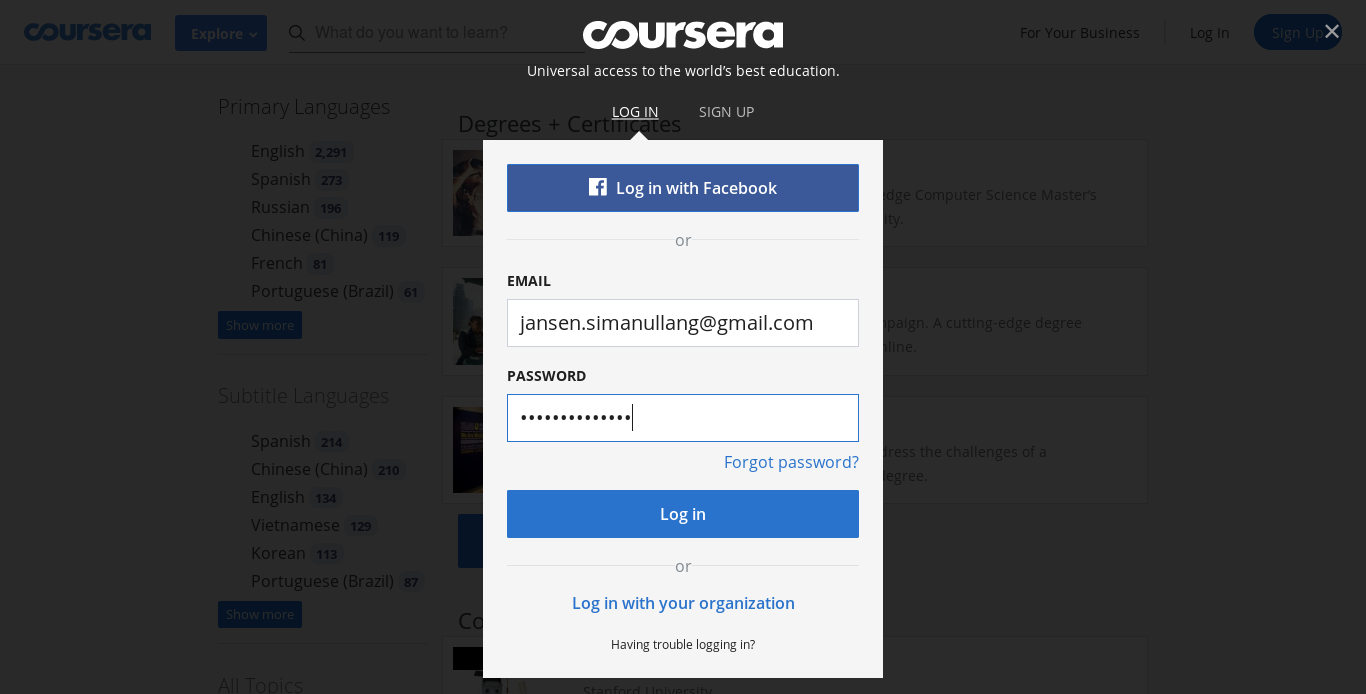

In [13]:
screenshot()

In [14]:
buttons = browser.find_by_tag('button')
for button in buttons:
    if (button.text == 'Log in'):
        button.click()
        break

###  <a name="last-active-courses"><b style="color:royalblue">LAST ACTIVE COURSES</b></a>

In [82]:
browser.visit(homepage)
section = browser.find_by_tag('section')
titles = []

for s in section:
    title = s.find_by_tag('h4').text
    titles.append(title)

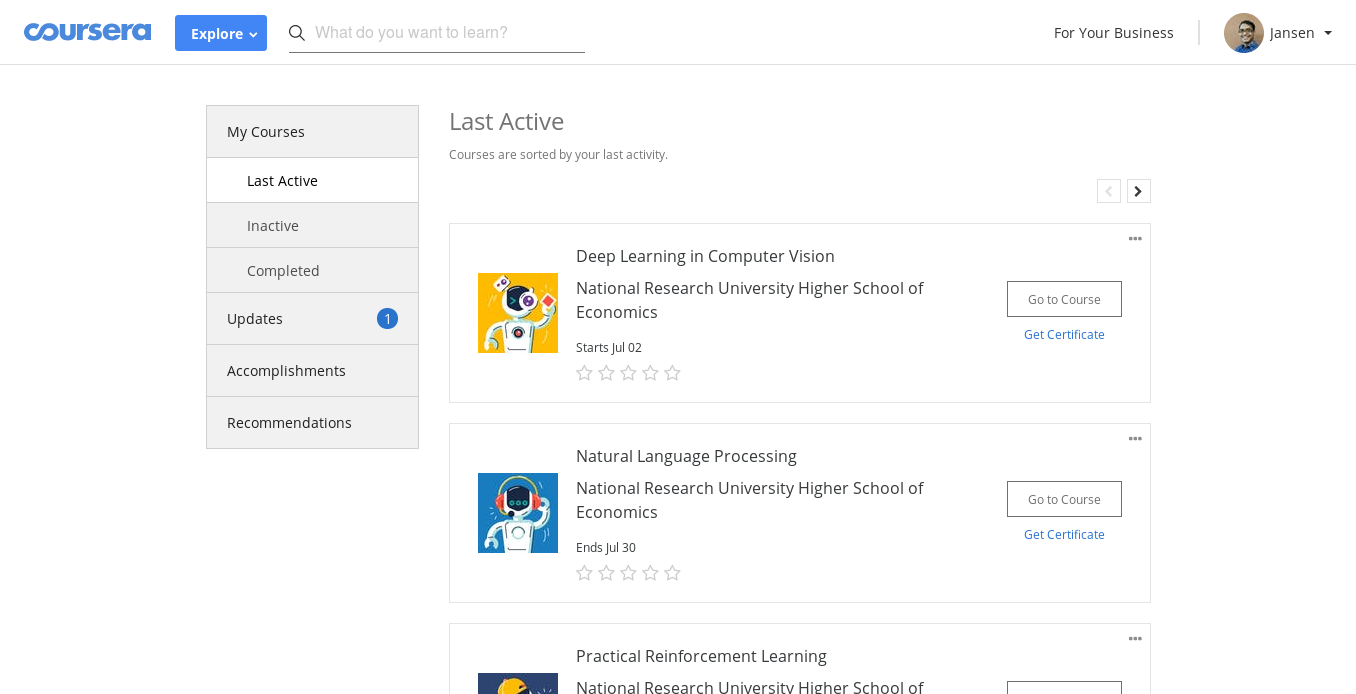

In [83]:
screenshot()

###  <b style="color:royalblue">PICK ONE OF THE COURSES</b>
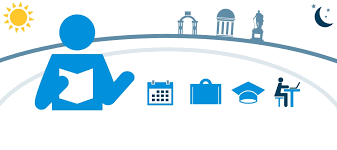

There are {{len(titles)}} courses visible in this section you can pick to download.

In [84]:
for i, title in enumerate(titles):
    print(i+1, title)
try:
    chosen_course = int(input('Choose a course number from [1] to ['+ str(len(titles))+']:\n'))
except:
    chosen_course = 1
course_title = titles[chosen_course-1]
print('>> You choose:\n'+course_title)

1 Deep Learning in Computer Vision
2 Natural Language Processing
3 Practical Reinforcement Learning
4 Bayesian Methods for Machine Learning
5 Data Structures
6 Algorithmic Toolbox
7 Introduction to Deep Learning
8 How to Win a Data Science Competition: Learn from Top Kagglers
9 Software Architecture
10 How Google does Machine Learning
11 Exploratory Data Analysis
12 Exploratory Data Analysis
13 Reproducible Research
Choose a course number from [1] to [13]:
2
>> You choose:
Natural Language Processing


 ### {{ titles[chosen_course-1] }}

In [85]:
section[chosen_course-1].click()
create_download_dir(course_title)

/home/bri/Development/my-github/www-coursera-downloader/Natural Language Processing


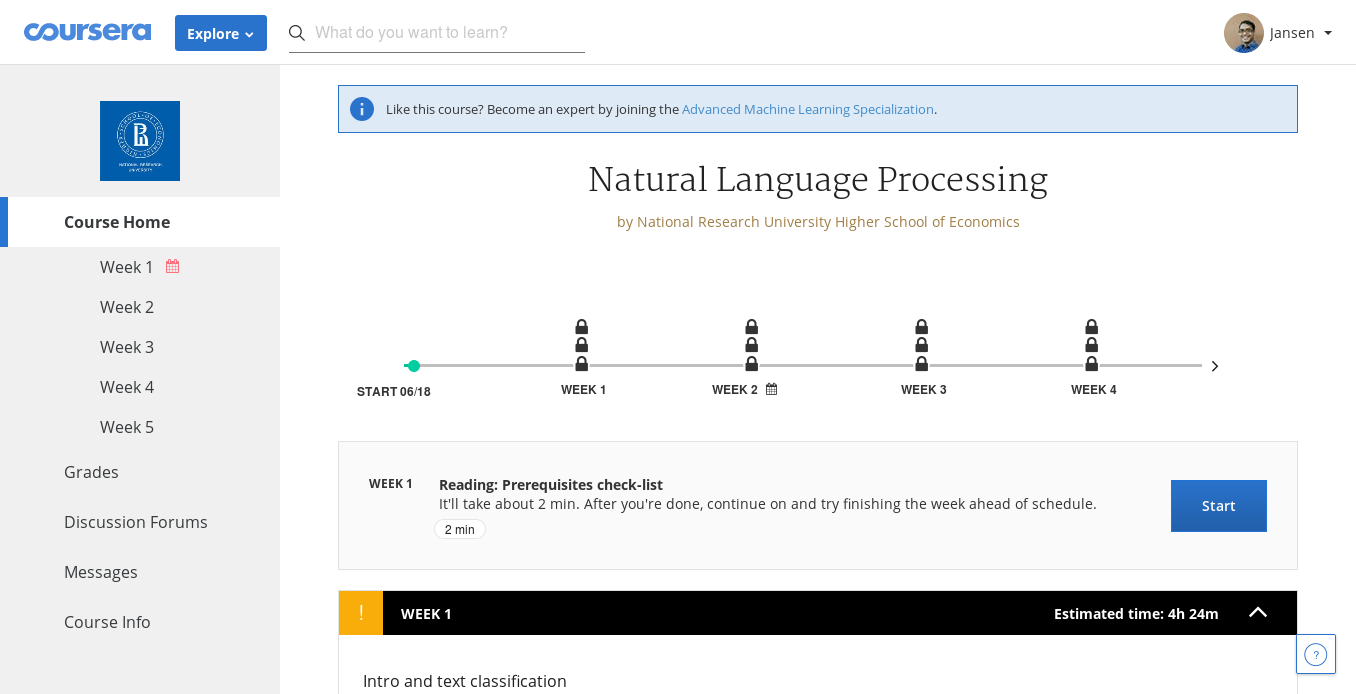

In [86]:
screenshot()

In [87]:
lecture_homepage = browser.driver.current_url

####  <b style="color:#3b5998">Enumerate Weeks</b>
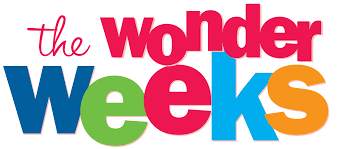

In [88]:
week = browser.find_by_css('div.rc-WeekCollectionNavigationItem > div')
anchors = BeautifulSoup(week.html, 'lxml').findAll('a', attrs={})
weeks = []
for a in anchors:
    weeks.append(a['href'])

weeks, len(weeks)

(['/learn/language-processing/home/week/1',
  '/learn/language-processing/home/week/2',
  '/learn/language-processing/home/week/3',
  '/learn/language-processing/home/week/4',
  '/learn/language-processing/home/week/5'],
 5)

####  <b style="color:#3b5998">Enumerate Module Lessons</b>
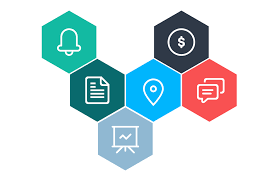

In [89]:
lessons_i = []
lessons_t = []
lessons_u = []
    
for w in range(len(weeks)):
    
    print('collecting lessons title and urls...\n')    
    browser.visit(homepage + weeks[w])
    time.sleep(loading_time)
    w = w+1
    
    print('\nVisiting week: ' + str(w))
    time.sleep(loading_time)
    module_lessons = browser.find_by_css('div.rc-ModuleLessons')
    print()
    print('Week '+str(w)+' titles:')
    seq = 0
    for i, module_lesson in enumerate(module_lessons):

        lessons_title = module_lesson.find_by_tag('h5')

        for j, l in enumerate(lessons_title):
            seq  += 1
            lesson_id = str(w*100+seq).zfill(3)
            title = l.text.replace('\n',' ')
            print(lesson_id, title)
            title = safe_text(title)
            lessons_t.append(title)
            lessons_i.append(lesson_id)
    
    print()
    print('Week '+str(w)+' links:')    
    seq = 0

    for i, module_lesson in enumerate(module_lessons):

        lessons_url = module_lesson.find_by_tag('ul')
    
        for j, e in enumerate(lessons_url):
            anchors = BeautifulSoup(e.html, 'lxml').findAll('a')
            for k, a in enumerate(anchors):
                seq += 1
                lesson_id = str(w*100+seq).zfill(3)
                lesson_url = a['href']
                print(lesson_id, lesson_url)
                lessons_u.append(lesson_url)
           
    print()

collecting lessons title and urls...


Visiting week: 1

Week 1 titles:
101 Lecture About this course
102 Reading Prerequisites check-list
103 Lecture Welcome video
104 Lecture Main approaches in NLP
105 Lecture Brief overview of the next weeks
106 Lecture [Optional] Linguistic knowledge in NLP
107 Lecture Text preprocessing
108 Lecture Feature extraction from text
109 Lecture Linear models for sentiment analysis
110 Lecture Hashing trick in spam filtering
111 Quiz: Classical text mining
112 Reading Getting started with practical assignments
113 Programming Assignment: Predict tags on StackOverflow with linear models
114 Lecture Neural networks for words
115 Lecture Neural networks for characters
116 Quiz: Simple neural networks for text

Week 1 links:
101 /learn/language-processing/lecture/akWLW/about-this-course
102 /learn/language-processing/supplement/7p5Lc/prerequisites-check-list
103 /learn/language-processing/lecture/cnBKV/welcome-video
104 /learn/language-processing/lecture/j8k

### Download Lecture Videos and Readings
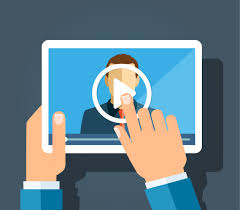

See the progress of downloading lecture videos, readings and quizzes.

In [ ]:
os.chdir(initial_dirname)
os.chdir(safe_text(course_title))
lessons = zip(lessons_i, lessons_t, lessons_u)
for a,b,c in lessons:
    print(a,b)
    first_word = b.split(' ')[0]
    
    if 'Lecture' in first_word:
        mp4_downloader(a,b,c)
        vtt_downloader(a,b,c)
        print()
        
    elif 'Reading' in first_word:
        check_html_reading(a, b, c)
        print()
        
    elif ('Quiz' in first_word) or ('Practice Quiz' in b):
        quiz_downloader(a, b, c)
        print()
    
    else:
        print('no resource to download.')
        
    print()
print('Resources downloaded to:\n'+os.getcwd())
os.chdir(initial_dirname)

101 Lecture About this course
video playing will be paused in 5 seconds...
requesting to download...
downloading...101-Lecture About this course.mp4>>> 100.01%vtt file being converted to srt: 101-Lecture About this course.vtt

101-Lecture About this course.srt
file created: 101-Lecture About this course.srt



102 Reading Prerequisites check-list
got reading item


103 Lecture Welcome video
video playing will be paused in 5 seconds...
requesting to download...
downloading...103-Lecture Welcome video.mp4>>> 100.01%vtt file being converted to srt: 103-Lecture Welcome video.vtt

103-Lecture Welcome video.srt
file created: 103-Lecture Welcome video.srt



104 Lecture Main approaches in NLP
video playing will be paused in 5 seconds...
requesting to download...
downloading...104-Lecture Main approaches in NLP.mp4>>> 100.00%vtt file being converted to srt: 104-Lecture Main approaches in NLP.vtt

104-Lecture Main approaches in NLP.srt
file created: 104-Lecture Main approaches in NLP.srt



105

### The Playlist
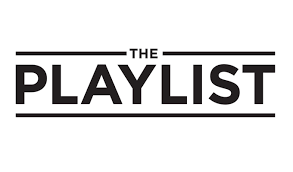

In [ ]:
os.chdir(initial_dirname)
os.chdir(safe_text(course_title))
create_m3u_playlist(course_title)
os.chdir(initial_dirname)

## <b style="color:#3b5998">D. Download Another Course?</b>

Click <a href="#last-active-courses">here</a> and RUN the cells and continue to choose another course. You may want to use your browser and open the corresponding course if the course is not seen the last active course list.

##  <b style="color:#3b5998">E. Error Checking</b>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQXcI6o52Fkp4wQV6fET12lDBZl1ZfqQpwdGP9265fpkVu3hc6k8Q">

###  <b style="color:#3b5998">(1) Screenshot Checking</b>

In case of an error, you may want to check the screenshot. Here is an example:

In [ ]:
screenshot()

###  <b style="color:#3b5998">(2) Manually Calling Downloader Functions</b>

In [ ]:
resource_idx = {}
lessons = zip(lessons_i, lessons_t, lessons_u)
for a,b,c in lessons:
    resource_idx[a] = {'title':b, 'url':c}

# USER'S HELPER FUNCTIONS

def quiz_download_by_id(idx):
    a = idx,
    b = resource_idx[a]['title']
    c = resource_idx[a]['url']
    quiz_downloader(a, b, c)
    
def mp4_download_by_id(idx):
    a = idx,
    b = resource_idx[a]['title']
    c = resource_idx[a]['url']
    mp4_downloader(a, b, c) 
    
def html_download_by_id(idx):
    a = idx,
    b = resource_idx[a]['title']
    c = resource_idx[a]['url']
    html_downloader(a, b, c)
    
def vtt_download_by_id(idx):
    a = idx,
    b = resource_idx[a]['title']
    c = resource_idx[a]['url']
    vtt_downloader(a, b, c)

### <b style="color:green">Examples of Manually Calling Functions</b>
<img src="https://images-na.ssl-images-amazon.com/images/I/41IRMu3-78L.jpg">

**`mp4_download_by_id`**

Example usage:

```
mp4_download_by_id('103')
```
is equivalent to:

**`mp4_downloader`** 

```
mp4_downloader('103',
               'Lecture Meet your lecturers',
               '/learn/competitive-data-science/lecture/k0D2h/meet-your-lecturers')
```
`103` means week `1` sequence number `03` which is a lecture

**`quiz_download_by_id`**
```
quiz_download_by_id('406')
```
is equivalent to:

**`quiz_downloader`** 

```
quiz_downloader('406',
               'Practice Quiz Practice quiz', 
               '/learn/competitive-data-science/quiz/k7xTP/practice-quiz')
```
`406` means week `4` sequence number `06` which is a quiz

In [ ]:
# Example usage, edit and uncomment as you wish
#mp4_download_by_id('103')

##  <b style="color:#3b5998">F. Finally Close the Browser After Download</b>
<img src="https://media.tenor.com/images/33c7bbf779e792d8a25ba1e5b80d8c9f/tenor.gif">

In [ ]:
browser.quit()
os.chdir(initial_dirname)
os.getcwd()